In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')

## Полиномиальная регрессия и оверфиттинг

In [2]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

## Обучаем модель с регуляризацией
@ignore_warnings(category=ConvergenceWarning)
def train_model(xs, ys, alpha=0, use_lasso=False):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

[ 1.23209083  0.02891773 -0.47948852]
[  3.63406651  -0.04508896 -11.23396419   6.07790317  15.22362293
 -10.31656846  -8.56510996   5.68964264   1.64793709  -1.02175028]


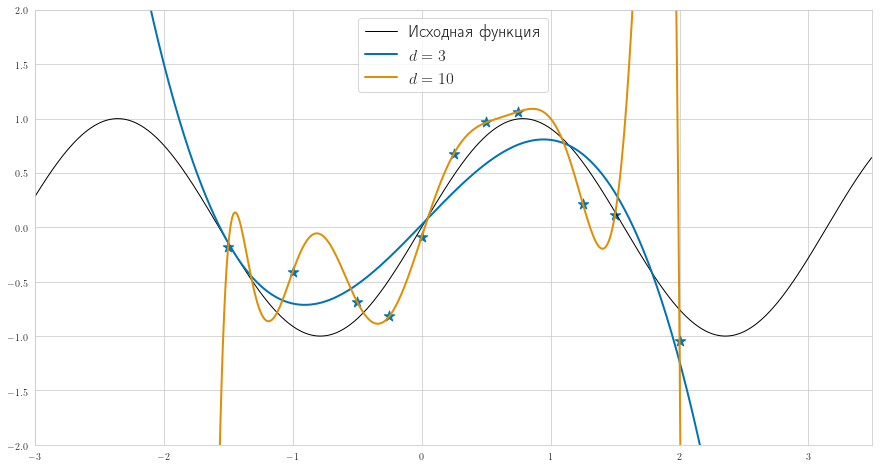

In [3]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 3, 10 ]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = train_model( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

# Байесовские предсказания в линейной регрессии

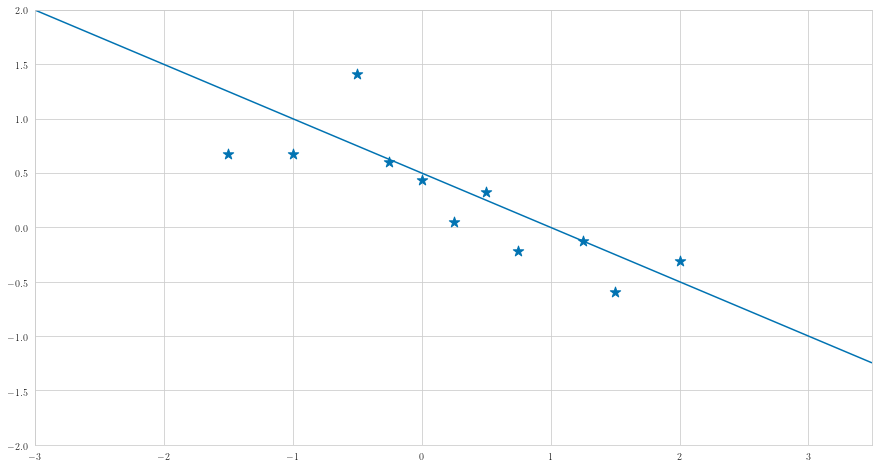

In [4]:
## Исходная функция
N = 250
true_mu = [.5, -.5]
def true_curve(x):
    return true_mu[0] + true_mu[1]*x


## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = true_curve(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.plot(xs, true_curve(xs))
ax.scatter(xd, data, marker='*', s=120)
plt.show()

In [5]:
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)

(250, 250)


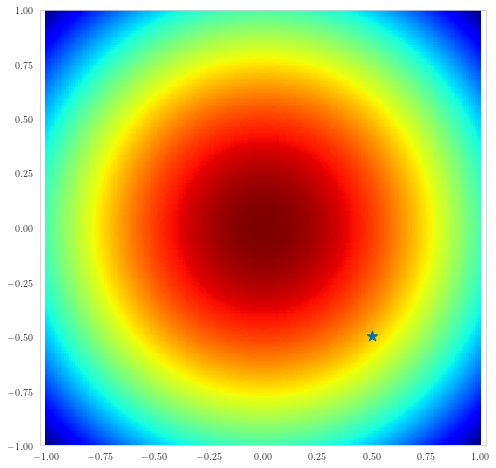

In [6]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

# plt.savefig("linregr_bayes1.png", dpi=150, bbox_inches="tight")

In [7]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((-3, 3))
    plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

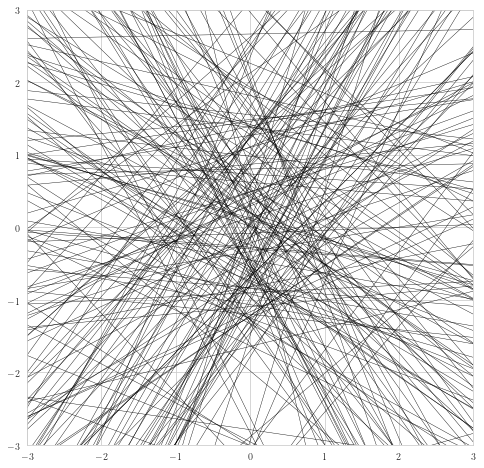

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 200)
# plt.savefig("linregr_bayes2.pdf", bbox_inches="tight")

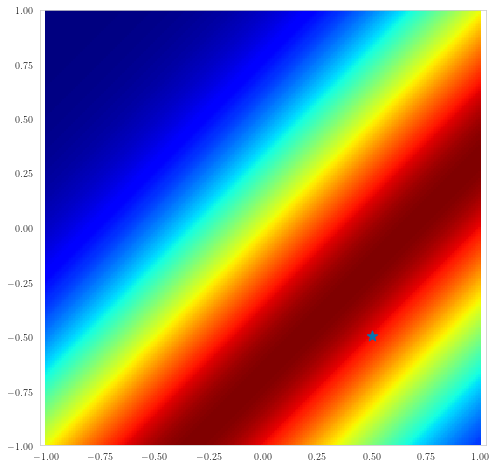

In [9]:
def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

px, py = xd[1], data[1]
cur_likelihood = get_likelihood(px, py)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

# plt.savefig("linregr_bayes3.png", dpi=150, bbox_inches="tight")

In [10]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

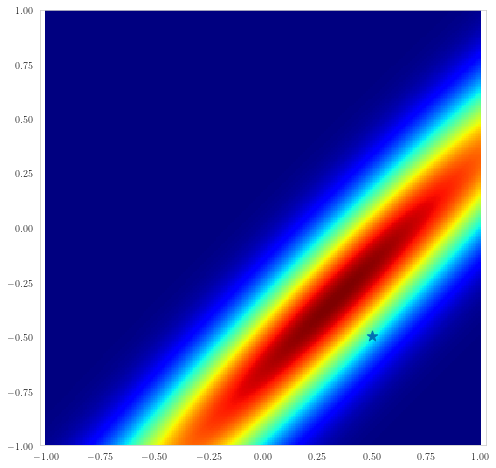

In [11]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

# plt.savefig("linregr_bayes4.png", dpi=150, bbox_inches="tight")

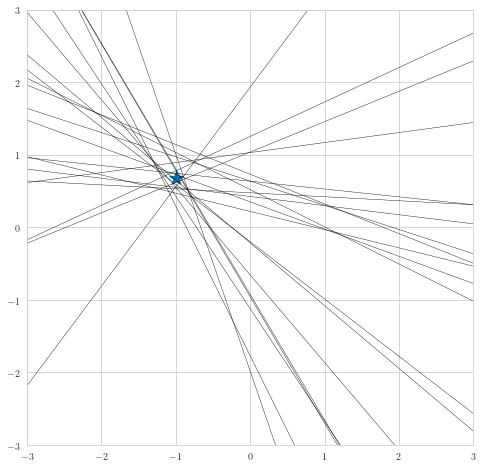

In [12]:
# Посэмплируем и порисуем прямые
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 20, points=[[px], [py]])
# plt.savefig("linregr_bayes5.pdf", bbox_inches="tight")

In [13]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [14]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 2))
    ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

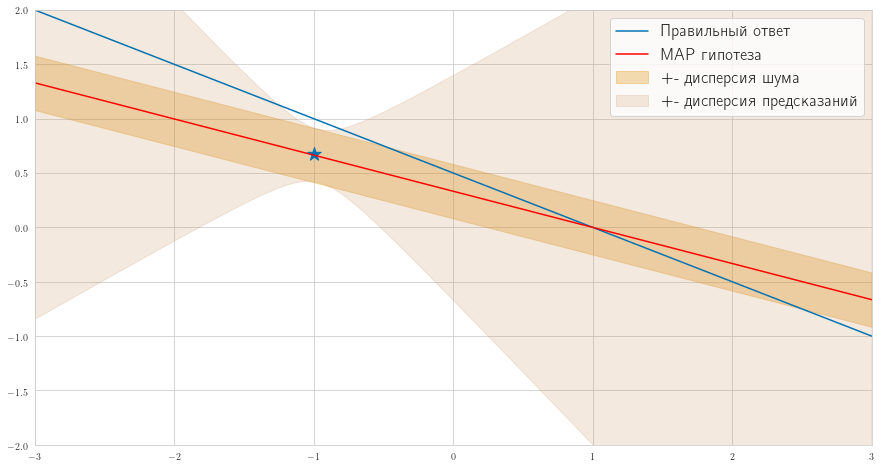

In [15]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
plot_predictions(xs, cur_mu, x, [[px], [py]])
# plt.savefig("linregr_bayes6.pdf", bbox_inches="tight")

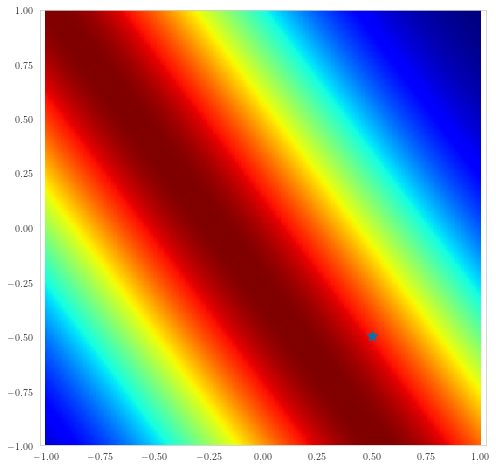

In [16]:
px2, py2 = xd[7], data[7]
cur_likelihood = get_likelihood(px2, py2)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

# plt.savefig("linregr_bayes7.png", dpi=150, bbox_inches="tight")

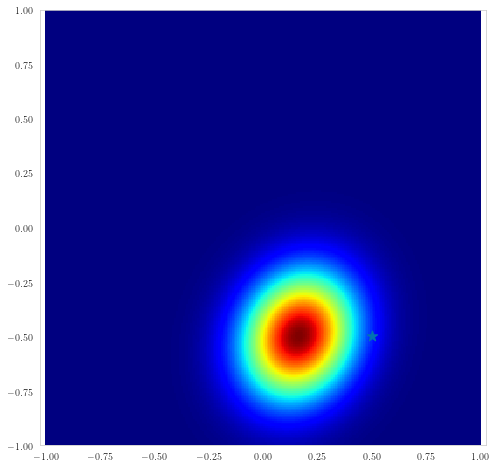

In [17]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px2, py2)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

# plt.savefig("linregr_bayes8.png", dpi=150, bbox_inches="tight")

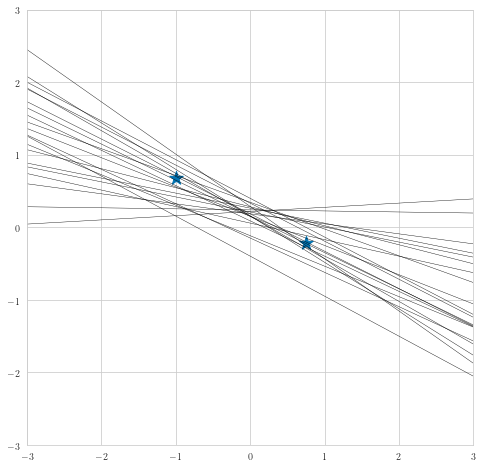

In [18]:
# Посэмплируем и порисуем прямые
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, n=20, points=[[px, px2], [py, py2]])
# plt.savefig("linregr_bayes9.pdf", bbox_inches="tight")

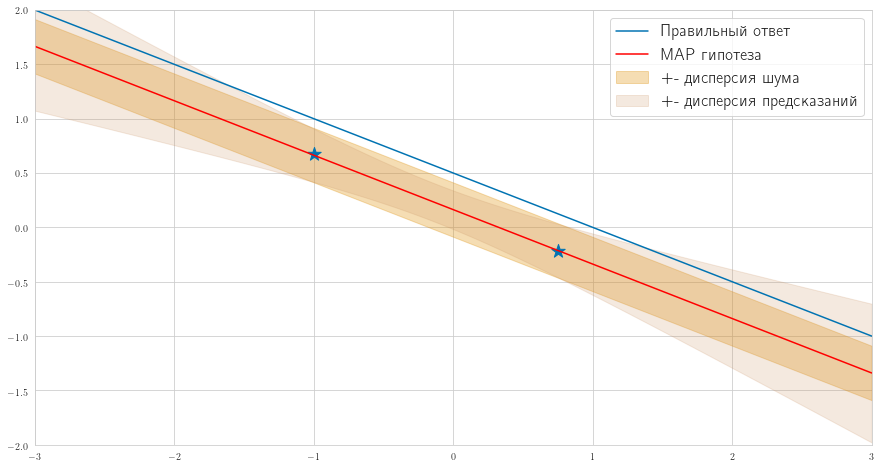

In [19]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=2000)
plot_predictions(xs, cur_mu, x, [[px, px2], [py, py2]])
# plt.savefig("linregr_bayes10.pdf", bbox_inches="tight")

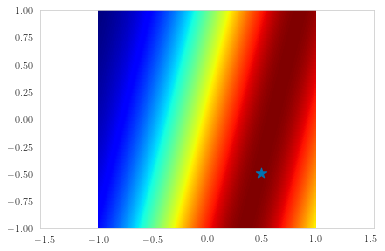

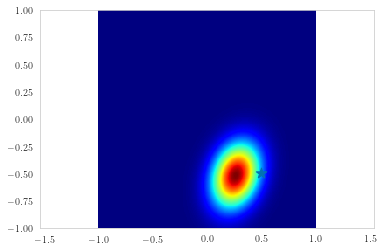

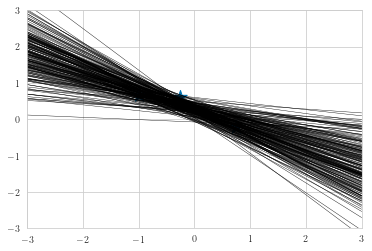

In [20]:
px3, py3 = xd[3], data[3]
cur_likelihood = get_likelihood(px3, py3)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
myplot_heatmap(Z)
plt.show()
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px3, py3)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)
plt.show()
myplot_sample_lines(cur_mu, cur_sigma, n=200, points=[[px, px2, px3], [py, py2, py3]])
plt.show()

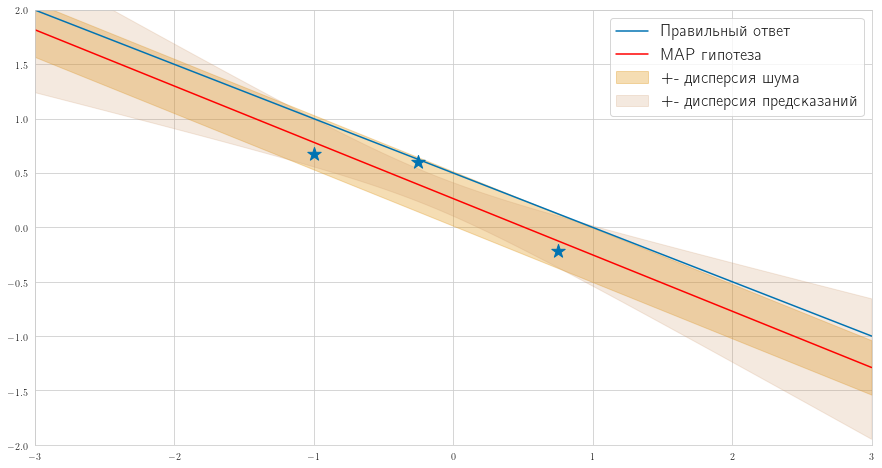

In [21]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=2000)
plot_predictions(xs, cur_mu, x, [[px, px2, px3], [py, py2, py3]])
# plt.savefig("linregr_bayes10.pdf", bbox_inches="tight")

## Статистическая теория принятия решений

ValueError: x and y must have same first dimension, but have shapes (250,) and (650,)

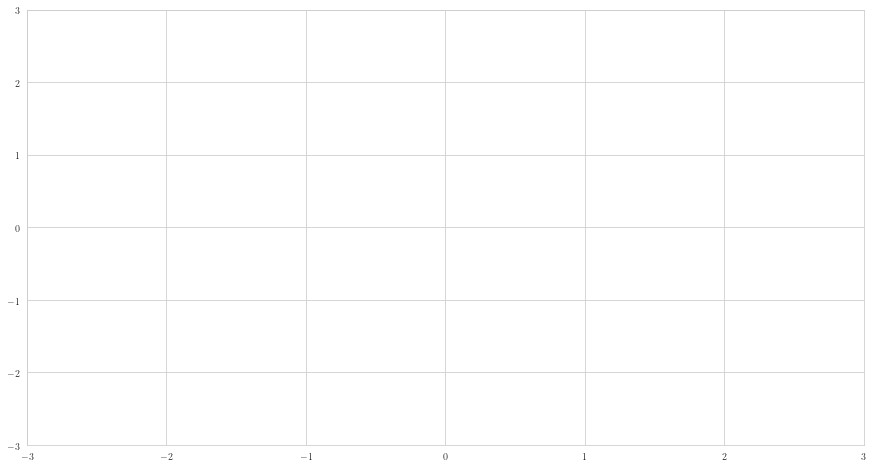

In [22]:
N = 50
alpha = 0.00001
use_lasso = True

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-3, 3))

res = []
for _ in range(N):
    cur_data = orig(xd) + np.random.normal(0, .25, num_points)
    cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
    res.append(cur_model.predict( xs_d ))
    ax.plot(xs, res[-1], linewidth=.1, color="0.5")

ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(xd, orig(xd), marker='*', s=150, color=palette[0])

ax.plot(xs, np.mean( res, axis=0 ), linewidth=2, label="Усреднённые предсказания", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )

In [ ]:
test_set_size = 30
test_set_x = np.random.rand(test_set_size) * (2 + 1.5) - 1.5
test_set_xs = np.vstack([test_set_x ** i for i in range(1, 12)]).transpose()
print(test_set_xs.shape)
test_set_y = orig(test_set_xs[:,0]) + np.random.normal(0, .25, test_set_size)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(test_set_xs[:,0], test_set_y, marker='*', s=150, color=palette[0])
ax.set_xlim((-1.5, 2))

def test_set_error(model, d):
    return np.mean( (test_set_y - model.predict(test_set_xs[:, :d])) ** 2 )

In [ ]:
N = 5000
use_lasso=False
alphas = np.logspace(-4, 2, num=20)
errors, biases, variances = [], [], []
for alpha in alphas:
    res, res_preds, res_test = [], [], []
    for _ in range(N):
        cur_data = orig(xd) + np.random.normal(0, .25, num_points)
        cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
        res.append(test_set_error(cur_model, xd_d.shape[1]))
        res_test.append(cur_model.predict(test_set_xs))
        res_preds.append(cur_model.predict( xs_d ))
    res_test = np.array(res_test)
    avg_preds = np.mean(res_test, axis=0)
    errors.append(np.mean(res))
    biases.append(np.mean((avg_preds-orig(test_set_x))**2))
    variances.append(np.mean((res_test-avg_preds)**2))
    print("alpha = %.6f\tmean error = %.6f\tbias = %.6f\tvariance = %.6f" % (alpha, errors[-1], biases[-1], variances[-1]))

In [ ]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# plt.yscale('log')
plt.xscale('log')
ax.plot(alphas, biases, linewidth=2, label="Bias")
ax.plot(alphas, variances, linewidth=2, label="Variance")
ax.plot(alphas, np.array(biases) + np.array(variances), linewidth=2, label="Bias + Variance")
ax.plot(alphas, errors, linewidth=2, label="Ошибка на тестовом множестве", color="black")
ax.set_ylim((0, 1))
ax.set_xlim((0.001, 100))
ax.legend(fontsize=legend_fontsize)
# fig.savefig('statdecision1.pdf', bbox_inches='tight')

## Эквивалентное ядро в линейной регрессии

In [ ]:
d = 1
x_pred = 1

new_data = np.copy(data)
new_data[7] = 0
cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], new_data )

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, new_data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")
ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)
y_pred = cur_model.predict(np.array([x_pred]).reshape(1,-1))
ax.scatter(x_pred, y_pred, marker='*', s=200)


print(data)
print(new_data)
print(y_pred)

In [ ]:
def get_one_prediction(x_pred, cur_y, d=1, data_ind=7, data=data):
    new_data = np.copy(data)
    new_data[data_ind] = cur_y
    cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], new_data )
    return cur_model.predict(np.array([x_pred]).reshape(1,-1))[0]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ys = np.arange(-1, 1, 0.1)
ax.set_xlim((ys[0], ys[-1]))

for x_pred in [-.5, 1, 1.5, 2]:
    one_pred = [ get_one_prediction(x_pred, y) for y in ys ]
    ax.plot(ys, one_pred, linewidth=1, label="Предсказание в точке %.2f" % x_pred)

ax.legend(fontsize=legend_fontsize)